In [51]:
import numpy as np
import pandas as pd
import os
import random
import matplotlib.pyplot as plt

from datetime import datetime
from time import time

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

from deap import base, creator, tools

import warnings
warnings.filterwarnings("ignore")

In [52]:
# Start time of Execution
time_start = time()

# Preprocessing

## Data Loading

In [53]:
def load_epigraph_data(file_path):
    try:
        df = pd.read_csv(file_path, sep='\t')
        return df
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        return None

# Update this to the correct path where your file is located
file_path = '/Users/ioannisvelgakis/Desktop/EpigraphRestoration/data.csv'

df = load_epigraph_data(file_path)

if df is not None:
    print("Data loaded successfully")
else:
    print("Data loading failed")

Data loaded successfully


In [54]:
df.head()

,id,text,metadata,region_main_id,region_main,region_sub_id,region_sub,date_str,date_min,date_max,date_circa
0,315181,[φ]ιλεταιρος ευμενου περγαμευς μουσαις. καφισι...,Boiotia — Thespiai — mid-3rd c. BC — BCH 26 (1...,1698,Central Greece (IG VII-IX),1691,"Megaris, Oropia, and Boiotia (IG VII)",mid-3rd c. BC,-275.0,-226.0,0.0
1,201686,μαλκοιδων ηρωνος.,"Crete, W. — Tarrha — 1st-3rd c. AD — IC II xxi...",1699,"Aegean Islands, incl. Crete (IG XI-[XIII])",474,Crete,1st-3rd c. AD,1.0,300.0,0.0
2,153178,βασιλικος.,Makedonia (Bottiaia) — Pella — 3rd/2nd c. BC —...,1692,Northern Greece (IG X),1485,Macedonia,3rd/2nd c. BC,-300.0,-101.0,0.0
3,28582,αισκλαπιει μ [ανεθεκε --].,Epidauria — Epidauros — sinistr. — 6th/5th c. BC,1690,Peloponnesos (IG IV-[VI]),1643,"Epidauria (IG IV²,1)",6th/5th c. BC,-600.0,-401.0,0.0
4,333620,[---]ος αν[εθηκε δαματρι].,Italia — Herakleia (Policoro) — late 4th/early...,1696,"Sicily, Italy, and the West (IG XIV)",1689,"Italy, incl. Magna Graecia",late 4th/early 3rd c. BC,-350.0,-251.0,0.0


In [55]:
def filter_epigraphs_by_region(df, region_id):
    return df[df['region_main_id'] == region_id]
filtered_epigraphs = filter_epigraphs_by_region(df, 1683)

## Text Encoding (Tokenization / Vectorization)

In [59]:
epigraph_texts.append(target_epigraph)
tfidf_matrix = vectorizer.fit_transform(epigraph_texts)
cosine_similarities = cosine_similarity(tfidf_matrix[-1], tfidf_matrix[:-1])
similarity_df = pd.DataFrame(cosine_similarities.T, columns=['similarity'])
similarity_df['text'] = epigraph_texts[:-1]
top_n = 5
top_similar_texts = similarity_df.nlargest(top_n, 'similarity')
top_vectors = vectorizer.transform(top_similar_texts['text'].tolist())

In [60]:
top_similar_texts

,similarity,text
0,0.0,[οσον] επαρκ[ει].
1,0.0,α[---]υς και [γυ]ν[η] φω[κ]αρια χαιρετε.
2,0.0,[αφ]ροδιτηι συριηι μητρω.
3,0.0,αγαθηι τυχηι. δημοκρατην αριστογενους προεδρον...
4,0.0,[---------- εν τω] ετει υπ[ερ -----] κατεσκε[υ...


In [8]:
NGRAM_RANGE = (1, 1) 
TOP_K = 1678
TOKEN_MODE = 'word'

In [24]:
def vectorize_texts(train_texts):
    kwargs = {
        'ngram_range': NGRAM_RANGE,
        'dtype': 'float32',
        'strip_accents': 'unicode',
        'decode_error': 'replace',
        'analyzer': TOKEN_MODE,
        'norm': 'l2',
        'max_features': TOP_K,
    }
    vectorizer = TfidfVectorizer(**kwargs)
    dataOut = vectorizer.fit_transform(train_texts)
    tokens = vectorizer.get_feature_names_out()

    # Map each token to a unique integer in the range [1, 1678]
    token_to_int = {token: idx + 1 for idx, token in enumerate(tokens)}

    return dataOut, tokens, vectorizer, token_to_int

# Genetic Algorithm

In [ ]:
class GeneticAlgorithmText:
    def __init__(self, epigraphs, target_epigraph, population_size, generations, crossover_rate, mutation_rate, elite_size, num_runs):
        self.epigraphs = epigraphs
        self.target_epigraph = target_epigraph
        self.population_size = population_size
        self.generations = generations
        self.crossover_rate = crossover_rate
        self.mutation_rate = mutation_rate
        self.elite_size = elite_size
        self.num_runs = num_runs
        self.vectorizer = TfidfVectorizer(ngram_range=(1, 1), 
                                          max_features=1678,
                                          analyzer='word',
                                          norm='l2',
                                          )
        self.transformed_epigraphs, self.tokens, self.vocabulary_dict = self.vectorize_texts(epigraphs)
        self.target_vector = self.vectorizer.transform([target_epigraph])
        self.dictionary_size = len(self.tokens)
        self.toolbox = base.Toolbox()
        self.setup_deap()

    def vectorize_texts(self, texts):
        tfidf_matrix = self.vectorizer.fit_transform(texts)
        tokens = self.vectorizer.get_feature_names_out()
        vocabulary = {word: idx + 1 for idx, word in enumerate(tokens)}
        return tfidf_matrix, tokens, vocabulary

    def create_individual(self):
        word_indices = random.sample(range(1, self.dictionary_size + 1), 2)
        return creator.Individual(word_indices)

    def decode_individual(self, individual):
        reverse_vocabulary_dict = {v: k for k, v in self.vocabulary_dict.items()}
        words = [reverse_vocabulary_dict[idx] for idx in individual]
        return f" {words[0]} αλεξανδρε ουδις {words[1]}"

    def fitness_function(self, individual):
        completed_epigraph = self.decode_individual(individual)
        completed_vector = self.vectorizer.transform([completed_epigraph])
        similarity = cosine_similarity(self.target_vector, completed_vector)
        fitness = similarity[0][0]
        print(f"Individual: {individual}, Completed Epigraph: {completed_epigraph}, Target Vector: {self.target_vector}, Completed Vector: {completed_vector}, Similarity: {similarity}, Fitness: {fitness}")  # Detailed Debug statement
        return (fitness,)  # Return as a tuple


    def setup_deap(self):
        creator.create("FitnessMax", base.Fitness, weights=(1.0,))
        creator.create("Individual", list, fitness=creator.FitnessMax)
        self.toolbox.register("individual", self.create_individual)
        self.toolbox.register("population", tools.initRepeat, list, self.toolbox.individual)
        self.toolbox.register("evaluate", self.fitness_function)
        self.toolbox.register("mate", tools.cxTwoPoint)
        self.toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.5)
        self.toolbox.register("select", tools.selTournament, tournsize=3)

    def run_single(self):
        population = self.toolbox.population(n=self.population_size)
        fitnesses = list(map(self.toolbox.evaluate, population))
        for ind, fit in zip(population, fitnesses):
            ind.fitness.values = fit

        best_fitnesses = []
        stagnation_count = 0
        improvement_threshold = 0.01
        max_generations = self.generations
        best_fitness = max(fitnesses)[0]

        for g in range(max_generations):
            if best_fitness >= 100:
                break

            print(f"-- Generation {g} --")
            elite = tools.selBest(population, self.elite_size)
            offspring = self.toolbox.select(population, len(population) - self.elite_size)
            offspring = list(map(self.toolbox.clone, offspring))

            for child1, child2 in zip(offspring[::2], offspring[1::2]):
                if random.random() < self.crossover_rate:
                    self.toolbox.mate(child1, child2)
                    del child1.fitness.values
                    del child2.fitness.values

            for mutant in offspring:
                if random.random() < self.mutation_rate:
                    self.toolbox.mutate(mutant)
                    del mutant.fitness.values

            invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
            fitnesses = map(self.toolbox.evaluate, invalid_ind)
            for ind, fit in zip(invalid_ind, fitnesses):
                ind.fitness.values = fit

            population[:] = elite + offspring

            fits = [ind.fitness.values[0] for ind in population]
            current_best_fitness = max(fits)
            best_fitnesses.append(current_best_fitness)
            print(f"Best fitness of current generation: {current_best_fitness}")

            if g > 0 and (current_best_fitness - best_fitness) < improvement_threshold:
                stagnation_count += 1
            else:
                stagnation_count = 0

            best_fitness = current_best_fitness

            if stagnation_count >= 50:
                print("Termination: Stagnation limit reached")
                break

        best_individual = tools.selBest(population, 1)[0]
        return best_individual, best_fitnesses


    def run(self):
        best_individuals = []
        num_generations = []
        avg_fitness_per_gen = []

        for _ in range(self.num_runs):
            best_individual, best_fitnesses = self.run_single()
            best_individuals.append(best_individual.fitness.values[0])
            num_generations.append(len(best_fitnesses))

            if len(avg_fitness_per_gen) == 0:
                avg_fitness_per_gen = best_fitnesses
            else:
                avg_fitness_per_gen = [sum(x) / 2 for x in zip(avg_fitness_per_gen, best_fitnesses)]

        ave_best_fitness = np.mean(best_individuals)
        ave_generations = np.mean(num_generations)

        print("-- End of (successful) evolution --")
        print("Average best fitness over all runs:", ave_best_fitness)
        print("Average number of generations:", ave_generations)

        plt.plot(avg_fitness_per_gen)
        plt.xlabel('Generation')
        plt.ylabel('Average Best Fitness')
        plt.title('Evolution of Average Best Fitness Over Generations')
        plt.show()
        print(self.target_vector)
        return self.decode_individual(tools.selBest(self.toolbox.population(n=self.population_size), 1)[0])



# Execution - Evaluation

In [136]:
epigraph_texts = filtered_epigraphs['text'].tolist()
target_epigraph = "αλεξανδρε ουδις"
print(f'Target epigraph: {target_epigraph}\nepigraph samples: {epigraph_texts[:5]}')

Target epigraph: αλεξανδρε ουδις
epigraph samples: ['[οσον] επαρκ[ει].', 'α[---]υς και [γυ]ν[η] φω[κ]αρια χαιρετε.', '[αφ]ροδιτηι συριηι μητρω.', 'αγαθηι τυχηι. δημοκρατην αριστογενους προεδρον [μεν εισηγη]σαμενον ενδοξως [και δημηγ]ορησαντα δις δ α[ρξαντα την] [λαμπρο]τατην α[ρχην και πλεονακις] πρεσβευ[σ]αν[τα παρα τους] [σεβα]στους προικα υπερ τω[ν συμφεροντ]ων της πατριδος και τε[ιμηθε]ντα υπο της πολεως αιδιω[ι] [αναγ]ορευσει θιασαρχησαν[τα και] [πασ]αν λειτουργιαν τελεσαν[τα] [πολ]ειτευσαμενον εν πασιν αγνως τον κτιστην και ασυνκ[ρι]τον και φιλοπατριν η κρατιστη βουλη και ο ιερωτατος δημος ευνοιας χαριν.', '[---------- εν τω] ετει υπ[ερ -----] κατεσκε[υασε --- τον πυργ]γον τη π[ολει].']


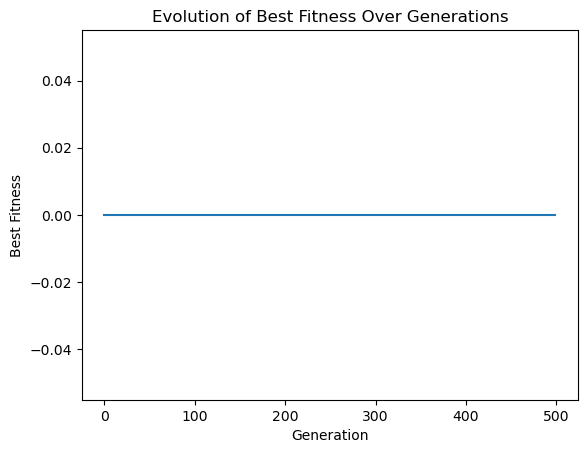

Best Epigraph:  ιερε αλεξανδρε ουδις υασε


In [137]:
epigraphs = epigraph_texts
target_epigraph = "αλεξανδρε ουδις"
ga = GeneticAlgorithmText(epigraphs, target_epigraph, population_size=100,
                           generations=200, crossover_rate=0.1, mutation_rate=0.01, elite_size=1, num_runs=10)
best_epigraph = ga.run()
print("Best Epigraph:", best_epigraph)

In [16]:
print(f'Took {(time() - time_start) / 60:.2f} minutes!')

Took 0.16 minutes!
